# Clustering Exploratory Data Analysis
Notebook to perform clustering analysis on data on BigQuery.<br>

## Imports

In [1]:
import json
import calendar
import datetime
import warnings
import numpy as np
import pandas as pd
from datetime import timedelta
from collections import Counter
from google.cloud import bigquery

from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')
tqdm.pandas()

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm.keras import TqdmCallback
from tensorflow.keras.utils import timeseries_dataset_from_array

2023-03-21 09:47:38.069635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 09:47:38.371463: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-21 09:47:38.507101: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-21 09:47:40.266932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Config

In [3]:
# Config

PROJECT_ID = 'arpae-prod-ml'

# BigQuery
JOINED_BQ_DATASET = 'JOINED_DATA'
JOINED_DATA_TABLE = "ALL_METEO_FEATS_POL_DAT"
JOINED_WEEK_DATA_TABLE = "ALL_METEO_WEEK_FEATS_POL_DAT"


## Methods

In [4]:
# # Read Methods

def _run_query(client, query): 
    df = client.query(query).to_dataframe()
    return df

def _create_station_widget(df):
    station_ids = df.station_id.sort_values().unique()
    station_wdgt = widgets.Dropdown(options=station_ids, description='Station Id:', layout={"width":"50%"})
    return station_wdgt

def _create_pol_var_id_widget(df):
    pol_var_ids = df.pol_var_id.sort_values().unique()
    pol_wdgt = widgets.Dropdown(options=pol_var_ids, description='Pol var id:', layout={"width":"50%"})
    return pol_wdgt

def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

# 1. Read Data

## 1.1 Config BigQuery

In [5]:
# Setup Client

bq_client = bigquery.Client()
bq_client

## 1.2 Read Tables

In [6]:
# Load B_CODES

sql = f"SELECT * FROM `{PROJECT_ID}.SAMPLE_DATA.B_CODES` WHERE eligible IS true"
b_codes = _run_query(bq_client, sql)

print(b_codes.shape)
b_codes.head(3)

(33, 3)


,var_id,var_descr,eligible
0,B48026,"Mirtacee_Mirtacee indistinte, POLLEN/M**3",True
1,B48006,"Composite_Artemisia, POLLEN/M**3",True
2,B48041,"Spore fungine_Stemphylium, POLLEN/M**3",True


In [7]:
# Load BCODE_SOGLIE

sql = f"SELECT * FROM `{PROJECT_ID}.SAMPLE_DATA.BCODE_SOGLIE`"
b_codes_soglie = _run_query(bq_client, sql)
b_codes_soglie.head(3)

,b_code,basso,medio,alto,CAL_01_JAN,CAL_02_FEB,CAL_03_MAR,CAL_04_APR,CAL_05_MAY,CAL_06_JUN,CAL_07_JUL,CAL_08_AUG,CAL_09_SEP,CAL_10_OCT,CAL_11_NOV,CAL_12_DEC
0,B48066,0.0,0.0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,B48081,3.0,25.0,50,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,B48082,3.0,25.0,50,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [8]:
# Load all meteo and pollen data

sql = f"""
    SELECT DISTINCT *
    FROM `{PROJECT_ID}.{JOINED_BQ_DATASET}.{JOINED_DATA_TABLE}`
    WHERE pol_var_id IN {tuple(b_codes.var_id)}
    ORDER BY station_id, pol_var_id, date
"""

raw_df = _run_query(bq_client, sql)

print(raw_df.shape)
raw_df.head(3)

(1362096, 33)


,station_id,date,B13011_min,B13011_max,B13011_mean,B13011_std,B13011_sum,B14198_min,B14198_max,B14198_mean,...,arkimet_id,arkimet_lat,arkimet_lon,meteo_id,pol_var_id,pol_value,modified,pol_var_descr,week,year
0,1,2006-03-01,0.0,0.0,0.0,0.0,0.0,-11.0,588.0,138.76,...,Bologna urbana,44.5008,11.3288,01421,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006
1,1,2006-03-02,0.0,0.0,0.0,0.0,0.0,-6.0,351.0,61.56,...,Bologna urbana,44.5008,11.3288,01421,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006
2,1,2006-03-03,0.0,0.0,0.0,0.0,0.0,-5.0,406.0,87.12,...,Bologna urbana,44.5008,11.3288,01421,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006


## 1.3 Load clustering results

In [9]:
clusters = pd.read_csv("data/clusters/clustering_tsd_intervals.csv")

print(clusters.shape)
clusters.sample(3)

(363, 3)


,station_id,pol_var_id,cluster
221,5,B48032,8
253,6,B48031,6
138,2,B48008,10


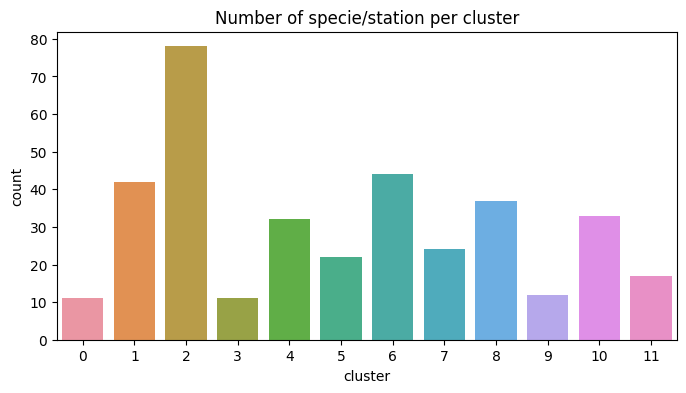

In [10]:
plt.figure(figsize=(8,4))
plt.title("Number of specie/station per cluster")
sns.countplot(x=clusters["cluster"]);

# 2. Data preprocess

In [11]:
raw_df.sort_values(["pol_var_id", "date"], inplace=True)

In [12]:
# Convert dates to datetime format
raw_df.date = pd.to_datetime(raw_df.date)

raw_df["month"] = raw_df.date.dt.month
# df["day"] = df.date.dt.day

In [13]:
# Set datetime as index
# raw_df.set_index(["pol_var_id", "station_id", "date"], inplace=True)
raw_df.set_index("date", inplace=True)

raw_df.head(3)

,station_id,B13011_min,B13011_max,B13011_mean,B13011_std,B13011_sum,B14198_min,B14198_max,B14198_mean,B14198_std,...,arkimet_lat,arkimet_lon,meteo_id,pol_var_id,pol_value,modified,pol_var_descr,week,year,month
date,,,,,,,,,,,,,,,,,,,,,
2006-03-01,1,0.0,0.0,0.000000,0.000000,0.0,-11.0,588.0,138.76,200.669770,...,44.5008,11.3288,01421,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006,3
2006-03-01,2,0.0,2.0,0.047541,0.244007,5.8,-9.0,513.0,115.08,161.071909,...,44.1382,12.2436,01989,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006,3
2006-03-01,4,0.0,0.0,0.000000,0.000000,0.0,-13.0,651.0,167.48,242.134109,...,44.8325,11.6211,01573,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006,3


In [14]:
### Sort dataset
raw_df.sort_values(by=['station_id', "pol_var_id", 'date'], ascending=True, inplace=True)

# 3. Feature process

## 3.1 Adding Seasonal trend as feature

In [15]:
seasonal_feature = "seasonal"

raw_df[seasonal_feature] = None
for (stat_id, specie_id), specie_data in tqdm(raw_df.groupby(["station_id", "pol_var_id"])):
    
    # Prepare specie data
    specie_data.sort_index(inplace=True)
    specie_pollen = specie_data[["pol_value"]].resample('D').interpolate()
    
    # Evaluate seasonal
    decomposition = seasonal_decompose(specie_pollen, period=365, model='additive')
    specie_seasonal = decomposition.seasonal
    
    # Join seasonal feautre
    mask = ((raw_df.station_id == stat_id) & (raw_df.pol_var_id == specie_id)) # get specie mask
    specie_seasonal = specie_seasonal.reindex(raw_df.loc[mask].index) # reindex due to index diff
    raw_df.loc[mask, seasonal_feature] = specie_seasonal # now we can add the seasonal feature

raw_df.seasonal = raw_df.seasonal.astype(float)

  0%|          | 0/363 [00:00<?, ?it/s]

# 4. Select data and generate windows

### 4.1 Select Cluster

In [16]:
cluster_n = 0

specie_cluster = clusters #[clusters.cluster == cluster_n] #.sample(1) ### .sample() is for debugging purpose!
specie_cluster

,station_id,pol_var_id,cluster
0,10,B48001,4
1,10,B48002,10
2,10,B48003,6
3,10,B48005,1
4,10,B48006,3
...,...,...,...
358,9,B48038,2
359,9,B48039,5
360,9,B48041,1
361,9,B48044,8


### 4.2 Select data

In [17]:
# Select species/stations from cluster result

df_feature = pd.merge(raw_df, specie_cluster, on=["station_id", "pol_var_id"], how="inner")
# df_feature = df_feature[features + [seasonal_feature, y_label]]
df_feature.station_id = df_feature.station_id.astype(int)
df_feature.dropna(inplace=True)

assert len(specie_cluster) == len(df_feature[["station_id", "pol_var_id"]].drop_duplicates())

print(df_feature.shape)
df_feature.head(5)

(1361784, 35)


,station_id,B13011_min,B13011_max,B13011_mean,B13011_std,B13011_sum,B14198_min,B14198_max,B14198_mean,B14198_std,...,meteo_id,pol_var_id,pol_value,modified,pol_var_descr,week,year,month,seasonal,cluster
0,1,0.0,0.0,0.000000,0.000000,0.0,-11.0,588.0,138.76,200.669770,...,01421,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006,3,-7.423273,4
1,1,0.0,0.0,0.000000,0.000000,0.0,-6.0,351.0,61.56,98.767015,...,01421,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006,3,-7.420884,4
2,1,0.0,0.0,0.000000,0.000000,0.0,-5.0,406.0,87.12,133.675702,...,01421,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006,3,-7.505362,4
3,1,0.0,0.0,0.000000,0.000000,0.0,-9.0,580.0,137.80,197.542822,...,01421,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006,3,-5.268076,4
4,1,0.0,7.2,0.360656,1.039593,44.0,-5.0,310.0,69.16,100.580266,...,01421,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",10,2006,3,-5.351214,4


### 4.3 Shift pollen value to predict by one day

In [18]:
### Applying shift here
df_feature['pol_value'] = df_feature.groupby(['station_id', 'pol_var_id'])['pol_value'].shift(-1)
df_feature.dropna(inplace=True)
df_feature.shape

(1361421, 35)

### 4.4 Previous days values as feature

In [19]:
# ### Pollen
# how_many_previous_days = 7
# columns_to_shift = 

# for shift_n in range(1, how_many_previous_days+1):
#     feat_name = f"pol_value_prev_{shift_n}D"
#     df_feature[feat_name] = df_feature.groupby(['station_id', 'pol_var_id'])['pol_value'].shift(+shift_n)

# # df_feature[["pol_value", 'pol_value_prev_1D', 'pol_value_prev_2D', 'pol_value_prev_3D', 'pol_value_prev_4D']].head(20)

# df_feature.dropna(inplace=True)
# df_feature.shape

In [20]:
### Pollen
how_many_previous_days = 5
columns_to_shift = ["pol_value", "PREC", "TEMP_max"]

for shift_n in range(1, how_many_previous_days+1):
    feat_names = [f"{col}_prev_{shift_n}D" for col in columns_to_shift]
    df_feature[feat_names] = df_feature.groupby(['station_id', 'pol_var_id'])[columns_to_shift].shift(+shift_n)

# df_feature[["pol_value", 'pol_value_prev_1D', 'pol_value_prev_2D', 'pol_value_prev_3D', 'pol_value_prev_4D']].head(20)

df_feature.dropna(inplace=True)
df_feature.reset_index(inplace=True)
df_feature.shape

(1359606, 51)

### 4.5 Specie and station are added as a categorical feature to our model

In [21]:
# le = LabelEncoder()
# df_feature["station_id"] = le.fit_transform(df_feature["station_id"])
# df_feature["pol_var_id"] = le.fit_transform(df_feature["pol_var_id"])

# print("Station id:", df_feature.station_id.unique())
# print("Pollen id:", df_feature.pol_var_id.unique())

stations_one_hot_encoded = pd.get_dummies(df_feature['station_id'], prefix='station_id')
pollen_one_hot_encoded = pd.get_dummies(df_feature['station_id'], prefix='pol_var_id')

# Add one-hot encoded values to original dataframe
df_feature = pd.concat([df_feature, stations_one_hot_encoded], axis=1)
df_feature = pd.concat([df_feature, pollen_one_hot_encoded], axis=1)

df_feature.head(5)

,index,station_id,B13011_min,B13011_max,B13011_mean,B13011_std,B13011_sum,B14198_min,B14198_max,B14198_mean,...,pol_var_id_2,pol_var_id_4,pol_var_id_5,pol_var_id_6,pol_var_id_7,pol_var_id_8,pol_var_id_9,pol_var_id_10,pol_var_id_11,pol_var_id_13
0,5,1,0.0,23.4,0.403279,2.959337,49.2,-8.0,649.0,159.56,...,0,0,0,0,0,0,0,0,0,0
1,6,1,0.0,0.4,0.003279,0.036214,0.4,-10.0,660.0,167.40,...,0,0,0,0,0,0,0,0,0,0
2,7,1,0.0,0.0,0.000000,0.000000,0.0,-14.0,649.0,163.60,...,0,0,0,0,0,0,0,0,0,0
3,8,1,0.0,0.0,0.000000,0.000000,0.0,-12.0,629.0,144.80,...,0,0,0,0,0,0,0,0,0,0
4,9,1,0.0,10.4,0.308197,1.129367,37.6,-8.0,610.0,97.80,...,0,0,0,0,0,0,0,0,0,0


### 4.6 Training and Test set split

In [22]:
y_label = "pol_value"

features = [
    #"station_id",
    #"pol_var_id",
    "month",
    "station_lat", "station_lon",
    "station_H_piano_strada", "station_H_mslm",
    "B13011_min", "B13011_max", "B13011_mean", "B13011_std",
    "B14198_min", "B14198_max", "B14198_mean", "B14198_std",
    "TEMP_min", "TEMP_max", "TEMP_mean", "TEMP_std",
    "PREC"
]

# Add previous pollen day
for col in columns_to_shift:
    shifted_feature_names = df_feature.keys()[df_feature.keys().str.contains(f"{col}_prev")]
    features.extend(shifted_feature_names.tolist())

# Add one hot encodings of station and species
station_one_hot = df_feature.keys()[df_feature.keys().str.contains("station_id_")]
features.extend(station_one_hot.tolist())

pollen_one_hot = df_feature.keys()[df_feature.keys().str.contains("pol_var_id_")]
features.extend(pollen_one_hot.tolist())

features = np.array(features)
print(f"{len(features)} features: {features}")

55 features: ['month' 'station_lat' 'station_lon' 'station_H_piano_strada'
 'station_H_mslm' 'B13011_min' 'B13011_max' 'B13011_mean' 'B13011_std'
 'B14198_min' 'B14198_max' 'B14198_mean' 'B14198_std' 'TEMP_min'
 'TEMP_max' 'TEMP_mean' 'TEMP_std' 'PREC' 'pol_value_prev_1D'
 'pol_value_prev_2D' 'pol_value_prev_3D' 'pol_value_prev_4D'
 'pol_value_prev_5D' 'PREC_prev_1D' 'PREC_prev_2D' 'PREC_prev_3D'
 'PREC_prev_4D' 'PREC_prev_5D' 'TEMP_max_prev_1D' 'TEMP_max_prev_2D'
 'TEMP_max_prev_3D' 'TEMP_max_prev_4D' 'TEMP_max_prev_5D' 'station_id_1'
 'station_id_2' 'station_id_4' 'station_id_5' 'station_id_6'
 'station_id_7' 'station_id_8' 'station_id_9' 'station_id_10'
 'station_id_11' 'station_id_13' 'pol_var_id_1' 'pol_var_id_2'
 'pol_var_id_4' 'pol_var_id_5' 'pol_var_id_6' 'pol_var_id_7'
 'pol_var_id_8' 'pol_var_id_9' 'pol_var_id_10' 'pol_var_id_11'
 'pol_var_id_13']


### 4.8 Generate windows for LSTM, in batches

In [35]:
X_features = df_feature[features]
X_seasonal = df_feature[[seasonal_feature]]
y = df_feature.pol_value

split_idx = int(len(X_features) * .95)

x_feature_train, x_seasonal_train, y_train = X_features[:split_idx], X_seasonal[:split_idx], y[:split_idx]
x_feature_test,  x_seasonal_test,  y_test =  X_features[split_idx:], X_seasonal[split_idx:], y[split_idx:]

print("Training shapes:", x_feature_train.shape, x_seasonal_train.shape, y_train.shape)
print("Test shapes:    ", x_feature_test.shape,  x_seasonal_test.shape,  y_test.shape)

Training shapes: (1291625, 55) (1291625, 1) (1291625,)
Test shapes:     (67981, 55) (67981, 1) (67981,)


In [36]:
def gen_win(x, window_size=window_day_size, stride=1):
    nw = ((x.shape[0] - window_size) // stride) + 1
    w = np.lib.stride_tricks.as_strided(x, shape=(nw, window_size, x.shape[1]), strides=(x.strides[0] * stride, x.strides[0], x.strides[1]))
    return w

x_feature_train = gen_win(x_feature_train.values)
x_seasonal_train = gen_win(x_seasonal_train.values)
y_train_w = gen_win(y_train.values.reshape(-1,1))

x_feature_test = gen_win(x_feature_test.values)
x_seasonal_test = gen_win(x_seasonal_test.values)
y_test_w = gen_win(y_test.values.reshape(-1,1))

print("Training window shapes:", x_feature_train.shape, x_seasonal_train.shape, y_train_w.shape)
print("Test window shapes:    ", x_feature_test.shape,  x_seasonal_test.shape,  y_test_w.shape)

Training window shapes: (1291619, 7, 55) (1291619, 7, 1) (1291619, 7, 1)
Test window shapes:     (67975, 7, 55) (67975, 7, 1) (67975, 7, 1)


### 4.9 Training/test split

In [26]:
# X = df_feature[np.hstack([features, [seasonal_feature]])]
# y = df_feature.pol_value

# split_idx = int(len(X) * .95)

# x_train, y_train = X[:split_idx], y[:split_idx]
# x_test, y_test = X[split_idx:], y[split_idx:]

# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [38]:
# training_size = .9

In [37]:
# ### Group by station and pollen
# groups = df_feature.groupby(["station_id", "pol_var_id"])

# ### Get training_size rows for each group
# training_idxs = groups.apply(lambda g: g.index.values[:int(len(g.index.values) * training_size)])
# training_idxs = np.hstack(training_idxs.values)

# ### Get test indexes as the remaining ones
# test_idxs = df_feature[~df_feature.index.isin(training_idxs)].index

# len(df_feature.index), len(training_idxs), len(test_idxs), (len(training_idxs)+len(test_idxs))==len(df_feature.index)

In [39]:
# X = df_feature[np.hstack([features, [seasonal_feature]])]
# y = df_feature.pol_value

# x_train, y_train = X.loc[training_idxs], y[training_idxs]
# x_test, y_test = X.loc[test_idxs], y[test_idxs]

# x_train.shape, y_train.shape, x_test.shape, y_test.shape

### 4.10 Create timeseries_dataset_from_array

In [33]:
# batch_size = 512
# window_day_size = 7

# train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
#     x_train,
#     y_train,
#     sequence_length=window_day_size,
#     batch_size=batch_size,
# )

# test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
#     x_test,
#     y_test,
#     sequence_length=window_day_size,
#     batch_size=batch_size,
# )

### 4.11 Feature Selection

In [31]:
# from sklearn.feature_selection import RFECV
# from sklearn.linear_model import LinearRegression
# X = np.hstack([X_features, X_seasonal])
# clf = LinearRegression().fit(X, y)
# selector = RFECV(clf, step=1, cv=5, n_jobs=-1)
# selector = selector.fit(X, y)
# features[selector.support_[:-1]]
# features[selector.ranking_[:-1]]

# 5. Model training

### Multiple Input, LSTM, Attention

In [32]:
# def get_model():
#     # Define model inputs
#     input_left = tf.keras.layers.Input(shape=(window_day_size, x_feature_train.shape[-1]))
#     input_right = tf.keras.layers.Input(shape=(window_day_size, x_seasonal_train.shape[-1]))

#     # Left branch
#     x1 = tf.keras.layers.LSTM(units=512, return_sequences=True)(input_left)
#     x1 = tf.keras.layers.LSTM(units=256)(x1)

#     # Right branch
#     x2 = tf.keras.layers.LSTM(units=512, return_sequences=True)(input_right)
#     x2 = tf.keras.layers.LSTM(units=256)(x2)

#     # Concatenate Left/Right input
#     # concatenated = tf.keras.layers.concatenate([x1, x2])
#     # concatenated = tf.keras.layers.Multiply([x1, x2])

#     ### With Attention layer
#     attn_layer = tf.keras.layers.Attention()([x1, x2])
#     attn_output = tf.keras.layers.Dense(units=64, activation="relu")(attn_layer)
#     # concatenated = tf.keras.layers.concatenate([concatenated, attn_output])

#     # Output layer
#     output_layer = tf.keras.layers.Dense(units=1)

#     # Define model architecture
#     model = tf.keras.models.Model(inputs=[input_left, input_right], outputs=output_layer(attn_output)) #concatenated))

#     n_epochs = 100
#     batch_size = 512
#     learning_rate = .005

#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss="mse")
#     return model

### Multiple Input, LSTM, MultiHeadAttention

In [33]:
# def get_model():
#     # Define model inputs
#     input_left = tf.keras.layers.Input(shape=(window_day_size, x_feature_train.shape[-1]))
#     input_right = tf.keras.layers.Input(shape=(window_day_size, x_seasonal_train.shape[-1]))

#     # Left branch
#     x1 = tf.keras.layers.LSTM(units=512, return_sequences=True)(input_left)
#     x1 = tf.keras.layers.LSTM(units=256, return_sequences=True)(x1)

#     # Right branch
#     x2 = tf.keras.layers.LSTM(units=512, return_sequences=True)(input_right)
#     x2 = tf.keras.layers.LSTM(units=256, return_sequences=True)(x2)

#     ### MultiHeadAttention Layer
#     attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=x1, value=x1, key=x2)
#     attn_output = tf.keras.layers.Dense(units=64, activation="relu")(attn_layer)
    
#     attn_lstm = tf.keras.layers.LSTM(units=64)(attn_output)
#     dense_lst = tf.keras.layers.Dense(units=16)(attn_lstm)

#     # Output layer
#     output_layer = tf.keras.layers.Dense(units=1)

#     # Define model architecture
#     model = tf.keras.models.Model(inputs=[input_left, input_right], outputs=output_layer(attn_lstm))

#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss="mse")
#     return model

### Multiple Input, LSTM, MultiHeadAttention

In [40]:
def get_model():
    # Define model inputs
    input_left = tf.keras.layers.Input(shape=(window_day_size, x_feature_train.shape[-1]))
    input_right = tf.keras.layers.Input(shape=(window_day_size, x_seasonal_train.shape[-1]))

    # Concatenate
    input_layer = tf.keras.layers.concatenate([input_left, input_right])
    
    dense_1 = tf.keras.layers.LSTM(units=256, return_sequences=True)(input_layer)

    ### Multi head attention
    # attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=input_layer, value=input_layer, key=input_layer)
    attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=dense_1, value=dense_1, key=dense_1)
    attn_output = tf.keras.layers.Dense(units=64, activation="relu")(attn_layer)

    # Reshape attention layer
    # reshape_size = (attn_output.shape[1] * attn_output.shape[2],)
    # att_reshape = tf.keras.layers.Reshape(reshape_size)(attn_output)
    att_reshape = tf.keras.layers.Flatten()(attn_output)

    # Dense layer
    dense_lst_1 = tf.keras.layers.Dense(units=512)(att_reshape)
    #dense_lst_2 = tf.keras.layers.Dense(units=256)(dense_lst_1)

    # Output layer
    output_layer = tf.keras.layers.Dense(units=1)

    # Define model architecture
    model = tf.keras.models.Model(inputs=[input_left, input_right], outputs=output_layer(dense_lst_1)) #2))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse")
    return model

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('data/model/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

n_epochs = 100
batch_size = 2048
learning_rate = .0001

!rm "data/model/best_model.h5"
model = get_model()
history = model.fit(
    (x_feature_train, x_seasonal_train),
    y_train_w,
    validation_data=((x_feature_test, x_seasonal_test), y_test_w),
    batch_size=batch_size,
    epochs=n_epochs,
    shuffle=True,
    verbose=0,
    callbacks=[early_stop, model_checkpoint, TqdmCallback(verbose=1)]
    # callbacks=[model_checkpoint, TqdmCallback(verbose=1)]
    # callbacks=[TqdmCallback(verbose=1)]
)

# Load the best model
print("Loading best model")
model = tf.keras.models.load_model('data/model/best_model.h5')

rm: cannot remove 'data/model/best_model.h5': No such file or directory


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-03-21 09:49:31.586961: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2023-03-21 09:49:31.773712: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-21 09:49:31.773734: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Restoring model weights from the end of the best epoch: 31.
Epoch 41: early stopping
Loading best model


In [43]:
# ## Test on training data
# predictions = model.predict((x_feature_train, x_seasonal_train))
# predictions = predictions.reshape(predictions.shape[0])
# mse = model.evaluate((x_feature_train, x_seasonal_train), y_train_w, verbose=False)

# plt.figure(figsize=(16,4))
# plt.title(f"Training Data Preditcions - MSE: {np.round(mse, 2)}")
# plt.plot(y_train.values, label="pol_value true")
# plt.plot(predictions, label="pol_value predicted")
# plt.legend(loc="upper right")
# plt.grid(alpha=.4)

2125/2125 [==============================] - 3s 1ms/step


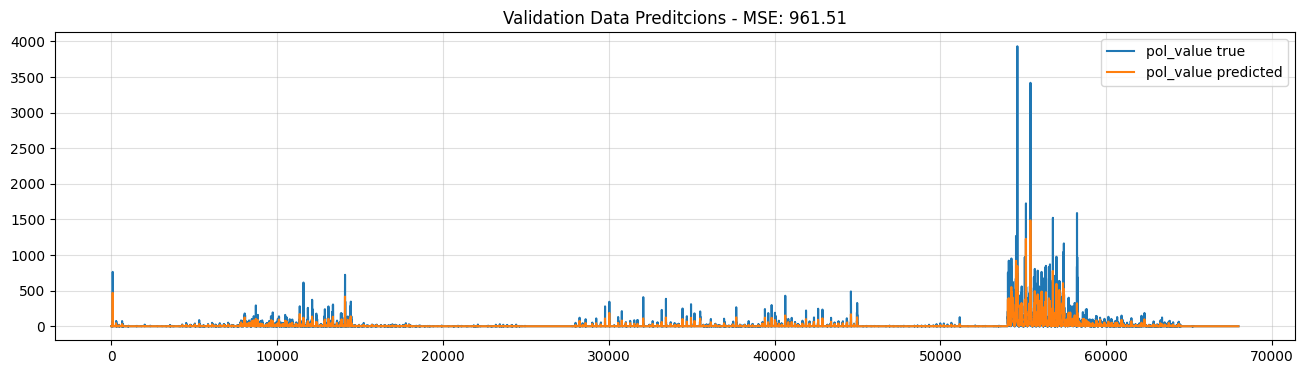

In [42]:
## Test on validation data
predictions = model.predict((x_feature_test, x_seasonal_test))
predictions = predictions.reshape(predictions.shape[0])
mse = model.evaluate((x_feature_test, x_seasonal_test), y_test_w, verbose=False)

plt.figure(figsize=(16,4))
plt.title(f"Validation Data Preditcions - MSE: {np.round(mse, 2)}")
plt.plot(y_test.values, label="pol_value true")
plt.plot(predictions, label="pol_value predicted")
plt.legend(loc="upper right")
plt.grid(alpha=.4)